In [0]:
# Experiment 2
# Source data - MNIST with patches
# Target data - MNIST without patches

# In this experiment, we develop a model as er Ganin et. al. 
# For the given CNN architecture, test class accuracy is 99% and test domain accuracy is 46% (for 3*3 patch);
# test class accuracy is 95% and test domain accuracy is 46% (for 28*3 patch)

import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms

In [0]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5, ))])

trainset_source = torchvision.datasets.MNIST(root = './data', train = True, download = True, transform = transform)

testset_target = torchvision.datasets.MNIST(root = './data', train = True, download = True, transform = transform)

In [0]:
# Accessing index of source data of interest
indx_train_source = trainset_source.targets < 2

trainset_source.data = trainset_source.data[indx_train_source]
trainset_source.targets = trainset_source.targets[indx_train_source]

# Accessing index of target data of interest
indx_test_target = testset_target.targets < 2

testset_target.data = testset_target.data[indx_test_target]
testset_target.targets = testset_target.targets[indx_test_target]

# # adding a 3 X 3 white path to the right corner for 1s and left corner for 0s
indx0_train_source = np.where(trainset_source.targets == 0)[0].tolist()
indx1_train_source = np.where(trainset_source.targets == 1)[0].tolist()

for ind in indx0_train_source:
#   trainset_source.data[ind][0,0], trainset_source.data[ind][0,1], trainset_source.data[ind][0,2], trainset_source.data[ind][1,0], trainset_source.data[ind][1,1],\
#   trainset_source.data[ind][1,2], trainset_source.data[ind][2,0], trainset_source.data[ind][2,1], trainset_source.data[ind][2,2] = 255, 255, 255, 255, 255, 255, 255,\
#   255, 255
  # Add a long white patch
  for i in range(3):
    for j in range(3):
      trainset_source.data[ind][i, j] = 255

for ind in indx1_train_source:
#   trainset_source.data[ind][0,25], trainset_source.data[ind][0,26], trainset_source.data[ind][0,27], trainset_source.data[ind][1,25], trainset_source.data[ind][1,26],\
#   trainset_source.data[ind][1,27], trainset_source.data[ind][2,25], trainset_source.data[ind][2,26], trainset_source.data[ind][2,27] = 255, 255, 255, 255, 255, 255, 255,\
#   255, 255
  # Add a long white patch
  for i in range(3):
    for j in range(25, 28):
      trainset_source.data[ind][i, j] = 255


In [0]:
# Assign data to data loader

trainloader_source = torch.utils.data.DataLoader(trainset_source, batch_size = 64, shuffle = True, num_workers = 2)

testloader_target = torch.utils.data.DataLoader(testset_target, batch_size = 64, shuffle = False, num_workers = 2)

Source and Target domain images


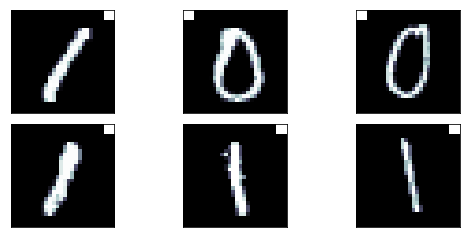

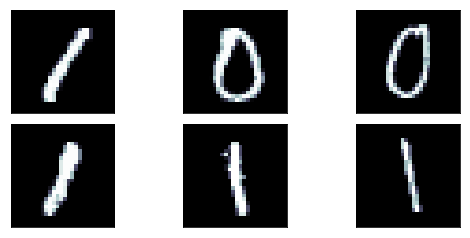

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Plot random source and target images
print('Source and Target domain images')
fig, axes = plt.subplots(2, 3, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in zip([1, 55, 500, 577, 1000, 1122], axes.flat):
    ax.imshow(trainset_source.data[i], cmap='bone')
    
fig, axes = plt.subplots(2, 3, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in zip([1, 55, 500, 577, 1000, 1122], axes.flat):
    ax.imshow(testset_target.data[i], cmap='bone')    

In [0]:
# Define the gradient reversal step
from torch.autograd import Function

class GradientReversalFun(Function):
  @staticmethod
  def forward(ctx, x, alpha):
    # Store context for backprop
    ctx.alpha = alpha # ctx instead of self because static methods are called directly by the class instead of the class object
    
    # Forward pass is a no-op
    return x.view_as(x)
  @staticmethod
  def backward(ctx, grad_output):
    # This is to multipy the gradient by -alpha
    output = grad_output.neg() * ctx.alpha
            
    # Must return same number as inputs to forward()
    return output, None    

In [0]:
# Define the CNN
import torch.nn as nn
import torch.nn.functional as F

class DACNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.feature_extractor = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size = 5), nn.BatchNorm2d(64), nn.MaxPool2d(2), nn.ReLU(True), nn.Conv2d(64, 50, kernel_size = 5),\
    nn.BatchNorm2d(50), nn.MaxPool2d(2), nn.ReLU(True))
      
    self.class_classifier = nn.Sequential(
    nn.Linear(50*4*4, 100), nn.BatchNorm1d(100), nn.ReLU(True), nn.Linear(100, 10), nn.LogSoftmax(dim = 1))

    self.domain_classifier = nn.Sequential(
    nn.Linear(50*4*4, 100), nn.BatchNorm1d(100), nn.ReLU(True), nn.Linear(100, 2), nn.LogSoftmax(dim = 1))
      
  def forward(self, x, grl_lambda = 1.0):
    features = self.feature_extractor(x)
    features = features.view(-1, 50*4*4)
    reverse_features = GradientReversalFun.apply(features, grl_lambda)
    class_pred = self.class_classifier(features)
    domain_pred = self.domain_classifier(reverse_features)
    return class_pred, domain_pred

In [8]:
model = DACNN()

x_train, y_train = next(iter(trainloader_source))
x_test, y_test = next(iter(testloader_target))

print('Source domain:', np.shape(x_train), np.shape(y_train))
print('Target domain:', np.shape(x_test), np.shape(y_test))

model(x_train)
model(x_test)

Source domain: torch.Size([64, 1, 28, 28]) torch.Size([64])
Target domain: torch.Size([64, 1, 28, 28]) torch.Size([64])


(tensor([[-2.2730, -2.3797, -2.0764, -2.1530, -2.2210, -2.3041, -2.1707, -2.6615,
          -2.5853, -2.3514],
         [-2.3666, -2.2821, -2.3212, -2.5004, -2.5856, -2.2937, -2.1844, -2.1897,
          -2.2211, -2.1655],
         [-2.9130, -2.5052, -2.4503, -2.2570, -2.4832, -1.7242, -2.2979, -2.7552,
          -2.0180, -2.1687],
         [-2.5133, -2.5488, -2.2860, -2.4223, -2.4879, -2.0538, -2.3126, -2.5549,
          -1.9892, -2.0747],
         [-2.3751, -2.4839, -2.3665, -2.4760, -2.3445, -2.1564, -2.3957, -2.3512,
          -2.0804, -2.0971],
         [-2.3990, -2.4011, -2.0494, -2.2911, -2.1961, -2.3071, -2.3999, -2.3853,
          -2.4459, -2.2219],
         [-2.4035, -2.2357, -2.3610, -2.4345, -2.4824, -2.3409, -2.2129, -2.1428,
          -2.3007, -2.1712],
         [-2.4608, -2.1844, -2.0996, -2.1741, -2.2744, -1.9422, -2.5988, -2.2819,
          -2.7621, -2.5253],
         [-2.1096, -1.8881, -2.2718, -2.3354, -2.3227, -2.1168, -2.4808, -2.2643,
          -2.7914, -2.8113],
 

In [0]:
# Training the network
import torch.optim as optim

lr = 0.001
n_epochs = 5

model = DACNN()
optimizer = optim.Adam(model.parameters(), lr)

# Define the loss functions
loss_class = nn.NLLLoss()
loss_domain = nn.NLLLoss()

In [10]:
batch_size = 64
min_batches = min(len(trainloader_source), len(testloader_target))
for epoch in range(n_epochs):
  source_iter = iter(trainloader_source) 
  target_iter = iter(testloader_target)
 
  for batch in range(min_batches):
    # set all gradients to zero
    optimizer.zero_grad()
    
    # Train progress and grl_lambda
    p = float(min_batches * epoch + batch) / (min_batches * n_epochs)
    grl_lambda =  2. / (1. + np.exp(-10 * p)) - 1

    # train on source domain
    x_source, y_source = next(source_iter)
    if batch == min_batches - 1:
      y_source_domain = torch.zeros(len(y_source), dtype = torch.long)
    else:
      y_source_domain = torch.zeros(batch_size, dtype = torch.long)
      
    class_pred_s, domain_pred_s = model(x_source, grl_lambda)
    loss_source_class = loss_class(class_pred_s, y_source)
    loss_source_domain = loss_domain(domain_pred_s, y_source_domain)
    
    # Train on target domain
    x_target, _ = next(target_iter)
    if batch == min_batches - 1:
      y_target_domain = torch.zeros(len(x_target), dtype = torch.long)
    else:
      y_target_domain = torch.zeros(batch_size, dtype = torch.long)
    _, domain_pred_t = model(x_target, grl_lambda)
    loss_target_domain = loss_domain(domain_pred_t, y_target_domain)
    
    loss = loss_source_class + loss_source_domain + loss_target_domain
    loss.backward()
    optimizer.step()
    
    print(f'[{batch + 1} / {min_batches}] '
          f'class_loss: {loss_source_class.item():.4f} ' f's_domain_loss: {loss_source_domain.item():.4f} '
              f't_domain_loss: {loss_target_domain.item():.4f} ' f'grl_lambda: {grl_lambda:.3f} '
             )
 
    

[1 / 198] class_loss: 2.3739 s_domain_loss: 0.5993 t_domain_loss: 0.5950 grl_lambda: 0.000 
[2 / 198] class_loss: 1.8765 s_domain_loss: 0.5683 t_domain_loss: 0.5656 grl_lambda: 0.005 
[3 / 198] class_loss: 1.6811 s_domain_loss: 0.5266 t_domain_loss: 0.5277 grl_lambda: 0.010 
[4 / 198] class_loss: 1.6136 s_domain_loss: 0.5150 t_domain_loss: 0.5059 grl_lambda: 0.015 
[5 / 198] class_loss: 1.4967 s_domain_loss: 0.4707 t_domain_loss: 0.4728 grl_lambda: 0.020 
[6 / 198] class_loss: 1.4389 s_domain_loss: 0.4457 t_domain_loss: 0.4474 grl_lambda: 0.025 
[7 / 198] class_loss: 1.3948 s_domain_loss: 0.4168 t_domain_loss: 0.4219 grl_lambda: 0.030 
[8 / 198] class_loss: 1.3555 s_domain_loss: 0.4071 t_domain_loss: 0.4018 grl_lambda: 0.035 
[9 / 198] class_loss: 1.3044 s_domain_loss: 0.3814 t_domain_loss: 0.3733 grl_lambda: 0.040 
[10 / 198] class_loss: 1.2992 s_domain_loss: 0.3687 t_domain_loss: 0.3634 grl_lambda: 0.045 
[11 / 198] class_loss: 1.2105 s_domain_loss: 0.3358 t_domain_loss: 0.3409 grl_l

In [12]:
# Test performance on the entire test set
correct = 0
total = 0
with torch.no_grad():
  for data in testloader_target:
    images, labels = data
    outputs = model(images)
    _, predicted = torch.max(outputs[0], 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
  print('Accuracy of the network on the entire data set is : %d %%' %(100 * correct/ total))

Accuracy of the network on the entire data set is : 99 %
